# 4.0 Prepare CITE-seq Dashboard

In [1]:
import bqplot as bq

import pandas as pd

import ipywidgets as widgets
import numpy as np
from bqplot import pyplot as plt
import bqplot
from ipywidgets import HBox
import umap

from clustergrammer2 import net
df = {}

In [2]:
import himc_helper_functions_v0_17_0 as hf

In [3]:
from copy import deepcopy

In [4]:
def make_df_from_cols(cols):
    inst_col = cols[0]

    cat_titles = []
    for inst_info in inst_col[1:]:
        inst_title = inst_info.split(': ')[0]
        cat_titles.append(inst_title)

    clean_cols = []
    for inst_col in cols:
        inst_clean = []
        for inst_info in inst_col:
            if ': ' in inst_info:
                inst_clean.append(inst_info.split(': ')[1])
            else:
                inst_clean.append(inst_info)
        clean_cols.append(tuple(inst_clean))

    df_ini = pd.DataFrame(data=clean_cols).set_index(0)
    mat = df_ini.get_values()
    rows = df_ini.index.tolist()

    print(mat.shape)
    print(len(rows))
    print(len(clean_cols))

    df_meta = pd.DataFrame(data=mat, index=rows, columns=cat_titles)

    return df_meta

In [5]:
def make_umap_plot(df, cat_index, colors_dict, title, min_dist=1.0, n_neighbors=20, s=5.0, alpha=1.0, 
                   figsize=(10,10)):
    cols = df.columns.tolist()
    cats = [x[cat_index] for x in cols]

    list_colors = [colors_dict[x.split(': ')[1]] for x in cats]
    
#     list_colors = []
#     for inst_index in range(len(cats)):
        
#         inst_cat = cats[inst_index]
        
#         # fix cd8 labeling
#         if inst_cat == 'Cell Type: CD8':

#             # print('HERE')
#             inst_cat = 'Cell Type: CD8__T_Cells'
            

#         inst_color = colors_dict[inst_cat.split(': ')[1]]
#         list_colors.append(inst_color)
    
    embedding = umap.UMAP(n_neighbors=n_neighbors, random_state=99,
                          min_dist=min_dist,
                          metric='correlation').fit_transform(df.transpose())
    
    df_umap = pd.DataFrame(data=embedding, columns=['x', 'y'])
    df_umap.plot(kind='scatter', x='x', y='y',  c=list_colors, alpha=alpha, s=s, figsize=figsize, 
                 title=title)
    
    return df_umap

In [6]:
cat_colors = net.load_json_to_dict('../data/category_colors.json')
cat_colors['Ungated'] = 'white'
cat_colors['CD8_CD4_T_Cells'] = '#D3D3D3'
cat_colors['PBMC'] = '#FF0000'
cat_colors['Plaque'] = '#2a3439'
cat_colors['Monocytes'] = '#808080'

In [7]:
cat_colors

{'CV7209': 'yellow',
 'CV7215': '#87ceeb',
 'CV7221': 'purple',
 'CV7223': '#00FF00',
 'CV7225': 'red',
 'CV7231': 'blue',
 'Asymptomatic': 'blue',
 'Symptomatic': 'red',
 'T_Cells': 'blue',
 'Monocytes': '#808080',
 'Macrophages': 'green',
 'NK_Cells': 'yellow',
 'NKT_Cells': '#800020',
 'B_Cells': 'purple',
 'pDCs': 'black',
 'Plasma_Cells': '#cc5500',
 'CD1c__DCs': '#ff9999',
 'CD4__T_Cells': 'blue',
 'CD8__T_Cells': 'red',
 'CD8_CD4_T_Cells': '#D3D3D3',
 'C-1': 'blue',
 'C-2': 'red',
 'C-3': 'grey',
 'C-4': 'black',
 'C-5': '#800020',
 'C-6': 'purple',
 'C-7': '#cc5500',
 'C-8': '#ff9999',
 'C-9': '#00ff00',
 'C-10': '#87ceeb',
 'C-11': 'yellow',
 'Ungated': 'white',
 'ADT': '#A52A2A',
 'GEX': '#D3D3D3',
 'PBMC': '#FF0000',
 'Plaque': '#2a3439'}

In [8]:
net.save_dict_to_json(cat_colors, '../data/citeseq-dashboard/category_colors.json')

In [9]:
def clean_cell_types(df):
    new_cols = [(x[0], x[1], x[2].split('-')[0]) if '-' in x[2] else x for x in df.columns.tolist()]

    clean_cols = []
    for new_col in new_cols:
        if new_col[2] == 'Cell Type: CD8':
            new_col = (new_col[0], new_col[1], 'Cell Type: CD8__T_Cells')
            
        clean_cols.append(new_col)
        
    df.columns = clean_cols
    return df

### Load Data

In [10]:
# net.load_file('../data/citeseq_adt_pbmc.txt')
# df['adt-pbmc'] = clean_cell_types(net.export_df())
# print('adt-pbmc', df['pbmc'].shape)

# net.load_file('../data/citeseq_adt_plaque.txt')
# df['adt-plaque'] = clean_cell_types(net.export_df())
# print('adt-plaque', df['plaque'].shape)

net.load_file('../data/citeseq_gex_pbmc-and-plaque.txt')
df['gex'] = clean_cell_types(net.export_df())
df['gex'].columns = [(x[0].split('-')[0], x[2], x[3]) for x in df['gex'].columns.tolist()]

df['gex'] = df['gex'][sorted(df['gex'].columns.tolist())]

print('gex pbmc and plaque', df['gex'].shape)

net.load_file('../data/citeseq_adt_merge.txt')
df['adt'] = clean_cell_types(net.export_df())
df['adt'] = df['adt'][sorted(df['adt'].columns.tolist())]
print('adt pbmc and plaque', df['adt'].shape)

gex pbmc and plaque (100, 5232)
adt pbmc and plaque (21, 5232)


### Initialize Metadata

In [11]:
df_meta = make_df_from_cols(df['adt'].columns.tolist())
df_meta.head()

(5232, 2)
5232
5232


,Tissue,Cell Type
AAACCTGCATACGCCG,PBMC,Monocytes
AAACCTGGTCTGCGGT,PBMC,NK_Cells
AAACCTGTCACCACCT,PBMC,CD8__T_Cells
AAACCTGTCATCGCTC,PBMC,CD4__T_Cells
AAACCTGTCATGTCTT,PBMC,Monocytes


### Clean Columns

In [12]:
cols_adt = [x[0] for x in df['adt'].columns.tolist()]
cols_gex = [x[0] for x in df['gex'].columns.tolist()]

df['adt'].columns = cols_adt
df['gex'].columns = cols_gex

In [13]:
new_cols = hf.add_cats_from_meta(cols_adt, add_cat_list=['Cell Type', 'Tissue'], df_meta=df_meta)
df['adt'].columns = new_cols
df['gex'].columns = new_cols

In [14]:
len(set(cols_gex).intersection(cols_adt))

5232

In [15]:
df['gex'].head()

,"(AAACCTGCATACGCCG, Cell Type: Monocytes, Tissue: PBMC)","(AAACCTGGTCTGCGGT, Cell Type: NK_Cells, Tissue: PBMC)","(AAACCTGTCACCACCT, Cell Type: CD8__T_Cells, Tissue: PBMC)","(AAACCTGTCATCGCTC, Cell Type: CD4__T_Cells, Tissue: PBMC)","(AAACCTGTCATGTCTT, Cell Type: Monocytes, Tissue: PBMC)","(AAACGGGAGATGCCAG, Cell Type: CD4__T_Cells, Tissue: PBMC)","(AAACGGGAGGTGCACA, Cell Type: Monocytes, Tissue: PBMC)","(AAACGGGAGTGCCAGA, Cell Type: CD8_CD4_T_Cells, Tissue: Plaque)","(AAACGGGCACCCTATC, Cell Type: Monocytes, Tissue: PBMC)","(AAACGGGCAGACTCGC, Cell Type: B_Cells, Tissue: PBMC)",...,"(TTTGGTTTCATGTGGT, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGGTTTCGAGAACG, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGGTTTCGCCTGTT, Cell Type: NK_Cells, Tissue: PBMC)","(TTTGGTTTCGCGATCG, Cell Type: NK_Cells, Tissue: PBMC)","(TTTGGTTTCGGCATCG, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGGTTTCTTGTACT, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGTCACAGGGATTG, Cell Type: pDCs, Tissue: Plaque)","(TTTGTCACATCACGAT, Cell Type: Macrophages, Tissue: Plaque)","(TTTGTCAGTATCACCA, Cell Type: NK_Cells, Tissue: PBMC)","(TTTGTCATCTACCTGC, Cell Type: NK_Cells, Tissue: Plaque)"
MALAT1,-0.78,0.17,-0.22,0.34,0.55,-0.26,-0.33,-0.46,-0.70,-0.08,...,-0.24,0.22,-0.53,-0.18,-0.01,-0.10,-0.88,-0.63,-0.18,1.49
TMSB4X,-1.12,0.32,-0.18,0.61,3.60,-0.20,1.47,-0.67,-0.94,0.12,...,-0.33,0.45,-0.82,-0.29,0.06,-0.02,-1.49,-0.82,-0.31,0.76
FTL,-0.19,-0.32,-0.14,-0.77,2.13,-0.23,2.85,-0.38,-0.12,-0.28,...,-0.42,-0.19,-0.48,-0.25,-0.45,-0.33,-0.73,-0.30,-0.74,-0.58
B2M,-1.35,0.78,0.17,0.65,-0.79,0.32,0.09,-0.68,-1.18,-0.27,...,-0.30,0.46,-0.74,-0.02,0.10,-0.22,-1.75,-1.08,0.02,0.31
LYZ,-0.15,-0.58,-0.58,-0.58,4.30,-0.58,3.60,-0.58,-0.05,-0.58,...,-0.46,-0.58,-0.58,-0.44,-0.58,-0.58,-0.55,-0.29,-0.58,-0.14


In [16]:
df['adt'].head()

,"(AAACCTGCATACGCCG, Cell Type: Monocytes, Tissue: PBMC)","(AAACCTGGTCTGCGGT, Cell Type: NK_Cells, Tissue: PBMC)","(AAACCTGTCACCACCT, Cell Type: CD8__T_Cells, Tissue: PBMC)","(AAACCTGTCATCGCTC, Cell Type: CD4__T_Cells, Tissue: PBMC)","(AAACCTGTCATGTCTT, Cell Type: Monocytes, Tissue: PBMC)","(AAACGGGAGATGCCAG, Cell Type: CD4__T_Cells, Tissue: PBMC)","(AAACGGGAGGTGCACA, Cell Type: Monocytes, Tissue: PBMC)","(AAACGGGAGTGCCAGA, Cell Type: CD8_CD4_T_Cells, Tissue: Plaque)","(AAACGGGCACCCTATC, Cell Type: Monocytes, Tissue: PBMC)","(AAACGGGCAGACTCGC, Cell Type: B_Cells, Tissue: PBMC)",...,"(TTTGGTTTCATGTGGT, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGGTTTCGAGAACG, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGGTTTCGCCTGTT, Cell Type: NK_Cells, Tissue: PBMC)","(TTTGGTTTCGCGATCG, Cell Type: NK_Cells, Tissue: PBMC)","(TTTGGTTTCGGCATCG, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGGTTTCTTGTACT, Cell Type: CD4__T_Cells, Tissue: PBMC)","(TTTGTCACAGGGATTG, Cell Type: pDCs, Tissue: Plaque)","(TTTGTCACATCACGAT, Cell Type: Macrophages, Tissue: Plaque)","(TTTGTCAGTATCACCA, Cell Type: NK_Cells, Tissue: PBMC)","(TTTGTCATCTACCTGC, Cell Type: NK_Cells, Tissue: Plaque)"
CD11b,1.607420,0.575467,-0.464362,-0.409320,1.765737,-0.661901,1.991477,-0.741397,0.715192,-0.661901,...,-1.031585,-0.741397,-0.117416,-0.226472,-0.829223,-0.741397,-0.661901,0.989210,0.332203,-0.741397
CD11c,2.170587,-0.299877,-0.604966,-0.857509,1.421516,-0.857509,1.474824,-0.604966,1.796123,-0.993075,...,-0.993075,-0.857509,-0.726954,-0.726954,-0.726954,-0.993075,-0.493176,2.302417,-0.140894,-0.857509
CD123,2.759403,-0.256251,-0.256251,-0.710943,3.999005,-0.582084,-0.077380,0.078994,2.713598,0.217641,...,-0.464304,-1.181463,-0.710943,-0.710943,-1.181463,-1.181463,5.000000,1.715797,-0.582084,-0.464304
CD14,1.444150,-0.334100,-0.610949,-0.948748,1.659982,-0.821245,1.291740,-1.181008,0.760581,-0.522283,...,-0.610949,-1.373823,-0.404453,-1.181008,-1.272861,-0.882733,-0.763746,1.237402,-0.882733,-1.272861
CD141,1.982562,-0.345171,-0.459174,-0.145253,0.931243,-0.459174,0.663218,-0.584484,1.248805,-1.043727,...,-0.345171,-0.722724,-0.875452,-0.345171,-0.145253,-0.584484,5.000000,1.409675,-0.345171,-1.043727


### UMAP ADT

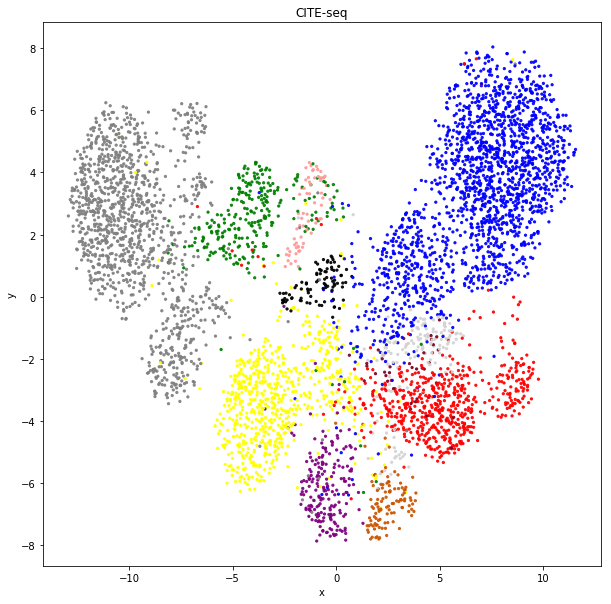

In [17]:
df_umap = make_umap_plot(df['adt'], 1, cat_colors, 'CITE-seq', alpha=0.9, n_neighbors=30, min_dist=1.0)

In [18]:
df_umap_adt = deepcopy(df_umap)
df_umap_adt.columns = ['adt-umap-x', 'adt-umap-y']
df_umap_adt.index = [x[0] for x in df['adt'].columns.tolist()]
df_umap_adt.head()

,adt-umap-x,adt-umap-y
AAACCTGCATACGCCG,-7.458114,-1.958771
AAACCTGGTCTGCGGT,-4.915214,-2.665281
AAACCTGTCACCACCT,3.918551,-4.742725
AAACCTGTCATCGCTC,9.371342,2.804928
AAACCTGTCATGTCTT,-10.326447,3.075937


### UMAP GEX

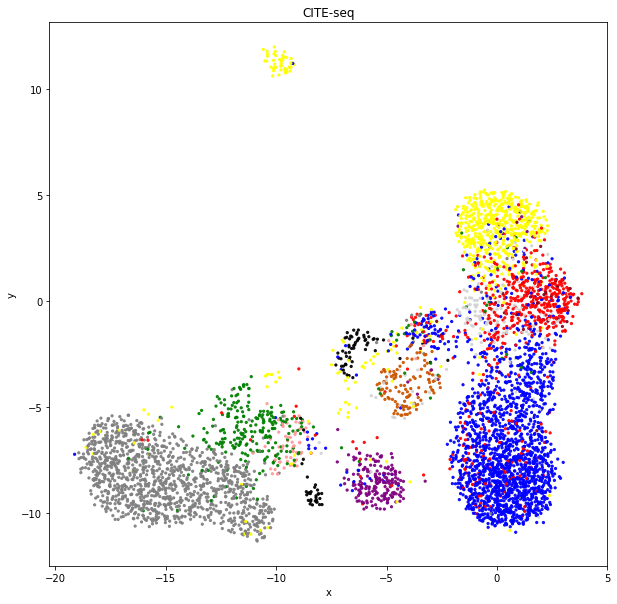

In [19]:
df_umap_gex = make_umap_plot(df['gex'], 1, cat_colors, 'CITE-seq', alpha=0.9, n_neighbors=30, min_dist=1)

In [20]:
df_umap_gex = deepcopy(df_umap_gex)
df_umap_gex.columns = ['gex-umap-x', 'gex-umap-y']
df_umap_gex.index = [x[0] for x in df['gex'].columns.tolist()]
df_umap_gex.head()

,gex-umap-x,gex-umap-y
AAACCTGCATACGCCG,-12.142960,-10.314715
AAACCTGGTCTGCGGT,-0.538951,3.673105
AAACCTGTCACCACCT,2.200991,1.773746
AAACCTGTCATCGCTC,-1.289661,-6.854154
AAACCTGTCATGTCTT,-16.400944,-6.582901


### Merge Datasets

In [21]:
df_adt_stack = deepcopy(df['adt'])
df_gex_stack = deepcopy(df['gex'])
print(df_adt_stack.shape, df_gex_stack.shape)

(21, 5232) (100, 5232)


In [22]:
df_adt_stack.index = [(x + '_A', 'Type: ADT') for x in df_adt_stack.index.tolist()]
df_gex_stack.index = [(x , 'Type: GEX') for x in df_gex_stack.index.tolist()]

In [23]:
df_merge = pd.concat([df_adt_stack, df_gex_stack], axis=0)
df_merge.shape

(121, 5232)

In [24]:
cat_colors['ADT'] = '#A52A2A'
cat_colors['GEX'] = '#D3D3D3'

In [25]:
net.load_df(df_merge)
net.set_cat_colors(axis='col', cat_title='Cell Type', cat_index=1, cat_colors=cat_colors)
net.set_cat_colors(axis='col', cat_title='Tissue', cat_index=2, cat_colors=cat_colors)
net.set_cat_colors(axis='row', cat_title='Type', cat_colors=cat_colors, cat_index=1)
net.clip(-5,5)
df_merge_norm = net.export_df()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "CD11b_A", "ini": 121, "clust": 62, "rank": 111, "rankvar": 110…

In [26]:
df_merge_export = deepcopy(df_merge_norm)
df_merge_export.columns = [x[0] for x in df_merge_export.columns.tolist()]
df_merge_export.index = [x[0] for x in df_merge_export.index.tolist()]
df_merge_export.to_parquet('../data/citeseq-dashboard/merge_data.parquet')

In [27]:
net.save_dict_to_json(inst_dict=net.viz, filename='../data/citeseq-dashboard/merge_viz.json', indent=False)

### UMAP Merge

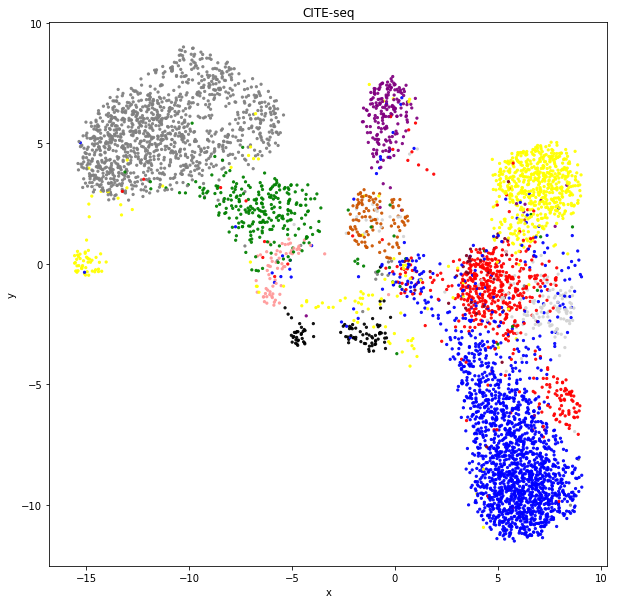

In [28]:
df_umap_merge = make_umap_plot(df_merge, 1, cat_colors, 'CITE-seq', alpha=0.9, n_neighbors=30, min_dist=1)

In [29]:
df_umap_merge = deepcopy(df_umap_merge)
df_umap_merge.columns = ['merge-umap-x', 'merge-umap-y']
df_umap_merge.index = [x[0] for x in df_merge.columns.tolist()]
df_umap_merge.head()

,merge-umap-x,merge-umap-y
AAACCTGCATACGCCG,-7.598949,7.475370
AAACCTGGTCTGCGGT,7.478775,3.168239
AAACCTGTCACCACCT,5.645874,-0.620094
AAACCTGTCATCGCTC,5.722888,-7.708591
AAACCTGTCATGTCTT,-12.482879,4.583138


In [30]:
df_umap_adt.head()

,adt-umap-x,adt-umap-y
AAACCTGCATACGCCG,-7.458114,-1.958771
AAACCTGGTCTGCGGT,-4.915214,-2.665281
AAACCTGTCACCACCT,3.918551,-4.742725
AAACCTGTCATCGCTC,9.371342,2.804928
AAACCTGTCATGTCTT,-10.326447,3.075937


In [31]:
df_umap_gex.head()

,gex-umap-x,gex-umap-y
AAACCTGCATACGCCG,-12.142960,-10.314715
AAACCTGGTCTGCGGT,-0.538951,3.673105
AAACCTGTCACCACCT,2.200991,1.773746
AAACCTGTCATCGCTC,-1.289661,-6.854154
AAACCTGTCATGTCTT,-16.400944,-6.582901


In [32]:
df_meta_new = pd.concat([df_umap_adt, df_umap_gex, df_umap_merge, df_meta], axis=1, sort=True)
df_meta_new.head()

,adt-umap-x,adt-umap-y,gex-umap-x,gex-umap-y,merge-umap-x,merge-umap-y,Tissue,Cell Type
AAACCTGCATACGCCG,-7.458114,-1.958771,-12.142960,-10.314715,-7.598949,7.475370,PBMC,Monocytes
AAACCTGGTCTGCGGT,-4.915214,-2.665281,-0.538951,3.673105,7.478775,3.168239,PBMC,NK_Cells
AAACCTGTCACCACCT,3.918551,-4.742725,2.200991,1.773746,5.645874,-0.620094,PBMC,CD8__T_Cells
AAACCTGTCATCGCTC,9.371342,2.804928,-1.289661,-6.854154,5.722888,-7.708591,PBMC,CD4__T_Cells
AAACCTGTCATGTCTT,-10.326447,3.075937,-16.400944,-6.582901,-12.482879,4.583138,PBMC,Monocytes


### Save Data to Parquets

In [33]:
!mkdir ../data/citeseq-dashboard/

mkdir: ../data/citeseq-dashboard/: File exists


In [34]:
df_meta_new

,adt-umap-x,adt-umap-y,gex-umap-x,gex-umap-y,merge-umap-x,merge-umap-y,Tissue,Cell Type
AAACCTGCATACGCCG,-7.458114,-1.958771,-12.142960,-10.314715,-7.598949,7.475370,PBMC,Monocytes
AAACCTGGTCTGCGGT,-4.915214,-2.665281,-0.538951,3.673105,7.478775,3.168239,PBMC,NK_Cells
AAACCTGTCACCACCT,3.918551,-4.742725,2.200991,1.773746,5.645874,-0.620094,PBMC,CD8__T_Cells
AAACCTGTCATCGCTC,9.371342,2.804928,-1.289661,-6.854154,5.722888,-7.708591,PBMC,CD4__T_Cells
AAACCTGTCATGTCTT,-10.326447,3.075937,-16.400944,-6.582901,-12.482879,4.583138,PBMC,Monocytes
AAACGGGAGATGCCAG,3.174891,2.298370,1.717567,-5.666244,3.970057,-6.145269,PBMC,CD4__T_Cells
AAACGGGAGGTGCACA,-11.479361,2.701975,-16.051746,-7.321879,-13.276303,4.827247,PBMC,Monocytes
AAACGGGAGTGCCAGA,1.977332,-3.999946,-6.216617,-8.196233,1.088472,4.760437,Plaque,CD8_CD4_T_Cells
AAACGGGCACCCTATC,-7.432421,-2.439124,-11.679908,-10.554111,-6.731674,7.343332,PBMC,Monocytes
AAACGGGCAGACTCGC,-0.867966,-6.097136,-4.714662,-7.880199,-0.955755,5.915055,PBMC,B_Cells


In [35]:
df_meta_new.to_parquet('../data/citeseq-dashboard/meta_cell.parquet')

In [36]:
# df['adt-export'] = deepcopy(df['adt'])
# df['adt-export'].columns = [x[0] for x in df['adt'].columns.tolist()]

In [37]:
# df['adt-export'].to_parquet('../data/citeseq-dashboard/adt.parquet')

### Save Metadata

In [38]:
df_meta_new.to_parquet('../data/citeseq-dashboard/meta_cell.parquet')